## Multiple Sequence Alignment

The aim of this notebook is to conduct a multiple sequence alignment (henceforth MSA). MSA methods refer to a series of algorithmic solution for the alignment of evolutionarily related sequences, while taking into account evolutionary events such as mutations, insertions, deletions and rearrangements under certain conditions. These methods can be applied to DNA, RNA or protein sequences. (https://academic.oup.com/bib/article/17/6/1009/2606431)
We will use the files of XML format (`curated_uniprot.fasta_`) with the information of hsp regions and the amino acid sequences.

In [29]:
# Importing the libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from Bio import AlignIO, SeqIO
import ipywidgets as widgets
from functions import json_parser, blast_parser, get_fasta, stats_calculation, trim_dis_regions, select_dis_regions, get_seqs

In [2]:
directory = "/Users/alina/HMM/"

### 1. Data Preparation

We have defined a function that parses an XML file with the BLAST alignment into a pandas dataframe. This function can be utilized to include any additional columns from the BLAST results.

In [3]:
input_file = '{}/curated_uniprot.fasta_75'.format(directory)
df = blast_parser(input_file)
df.head(5)

,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q16620,A0A2R9BM51,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,1,822,1,822,822,822,0,0.0,4458.0,200
1,Q16620,A0A4X2LP40,822,824,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,M SW + HGP MARL GFCWLV+ FWR + ACPTSC CS +RIWCS...,MLSWKKCHGPGMARLLGFCWLVLIFWRGSQACPTSCTCSTTRIWCS...,1,822,1,824,689,745,2,0.0,3749.0,200
2,Q16620,A0A4X2LDU8,822,822,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,M SW + HGP MARL GFCWLV+ FWR + ACPTSC CS +RIWCS...,MLSWKKCHGPGMARLLGFCWLVLIFWRGSQACPTSCTCSTTRIWCS...,1,822,1,821,689,745,1,0.0,3756.0,200
3,Q16620,A0A6P5IKH1,822,824,MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCS...,M SW + HGP MARL GFCWLV+ FWR + ACPTSC CS +RIWCS...,MLSWKKCHGPGMARLLGFCWLVLIFWRGSQACPTSCTCSTTRIWCS...,1,822,1,824,691,745,2,0.0,3764.0,200
4,Q16620,A0A7J7UQA2,822,741,TSCKCSASRIWCSDPSPGIVAFPRLEPNSVDPENITEIFIANQKRL...,+SCKCSASRIWCSDP PGI+AFPRLEPN++DPENITEI+IANQKRL...,SSCKCSASRIWCSDPIPGIMAFPRLEPNTIDPENITEIYIANQKRL...,34,774,2,739,710,724,3,0.0,3776.0,200


### Filtering disordered regions in MSA

We convert the file `curated.mjson` to dataframe in order to retrieve the IDs and disordered regions.

In [4]:
# Create a dataframe from curated.mjson
data = list()

with open('curated.mjson', 'r') as file:
    for line in file:
        obj = json.loads(line)
        rows = json_parser(obj)
        data.extend(rows)

curated_disprot = pd.DataFrame(data)

# Calculate the length of disordered regions
curated_disprot['length'] = curated_disprot['end'] - curated_disprot['start'] + 1
curated_disprot = curated_disprot[(curated_disprot['feature'] == 'disorder') & (curated_disprot['source'] == 'disprot')]

print(f"The number of the Curated Disprot database instances: {len(curated_disprot)}")
curated_disprot.head(5)

The number of the Curated Disprot database instances: 3151


,acc,evidence,feature,source,start,end,length
6927,P03265,curated,disorder,disprot,294,334,41
6928,P03265,curated,disorder,disprot,454,464,11
6929,P49913,curated,disorder,disprot,134,170,37
6930,P03045,curated,disorder,disprot,1,107,107
6931,P00004,curated,disorder,disprot,1,105,105


After identifying the IDs and disordered regions, we can use these data to filter the initial dataframe.

In [5]:
# Leaving only disordered regions in the initial dataframe
disordered = df[df['query_id'].isin(curated_disprot['acc'])]
disordered.to_csv("disordered_df.csv", index=False)

print(f"The number of rows containing disordered regions: {len(disordered)}")
disordered.head(5)

The number of rows containing disordered regions: 2887


,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
200,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
201,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGA GPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGATGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
202,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
203,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
204,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200


In [6]:
# Dropdown list of query IDs for disordered regions
output = widgets.Select(
    options=disordered["query_id"].unique(),
    rows=10,
    description='Query ID: ',
    layout={'width': 'max-content'},
    disabled=False
)
display(output)

Select(description='Query ID: ', layout=Layout(width='max-content'), options=('Q9H832', 'Q8IW19', 'Q99967', 'Q…

In [7]:
# Check if there are disordered regions for a particular query ID
id_dis = output.value
selected_dis = disordered[disordered["query_id"].isin([id_dis])]
print(f"Disordered region ID: {id_dis}")
selected_dis.head(5)

Disordered region ID: Q9H832


,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
200,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
201,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGA GPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGATGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
202,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
203,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
204,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200


In [8]:
# Filter the curated_disprot dataframe based on selected_id
filtered_curated = curated_disprot[curated_disprot['acc'] == id_dis]
filtered_curated.head(5)

,acc,evidence,feature,source,start,end,length
7799,Q9H832,curated,disorder,disprot,1,99,99
7800,Q9H832,curated,disorder,disprot,327,354,28


### 2. Query ID Analysis

Next, we determine the count of subject IDs for each query ID. It's important to note that we need to summarize the data for all subject IDs that occurred for a particular query, rather than for each individual 'query-sequence' pair.

The number of sequences containing disordered regions: 16


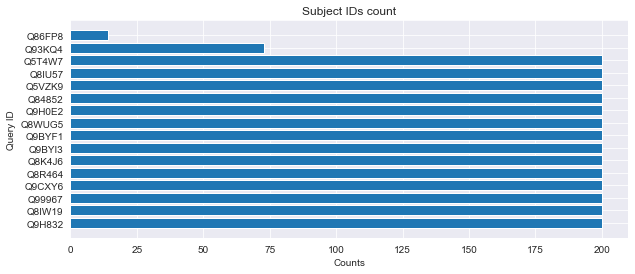

In [9]:
# Plot subject IDs count
figure(figsize=(10, 4))
plt.barh(disordered['query_id'], disordered['count'])
plt.xlabel('Counts')
plt.ylabel('Query ID')
plt.title('Subject IDs count')
print(f"The number of sequences containing disordered regions: {disordered['query_id'].nunique()}")
plt.show()

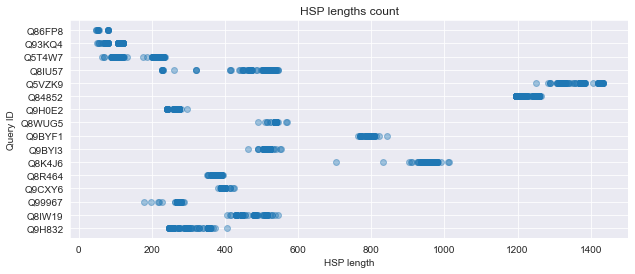

In [10]:
# Plot HSP length count
figure(figsize=(10, 4))
plt.scatter(disordered['hsp_len'], disordered['query_id'], alpha=0.4)
plt.xlabel('HSP length')
plt.ylabel('Query ID')
plt.title('HSP lengths count')
plt.show()

The scatterplot shows the positions of the sequences with the specific hsp length. The highest concentration represents the most frequent hsp length for a particular query ID.

Once the query ID list is generated, we need to select one of the IDs.

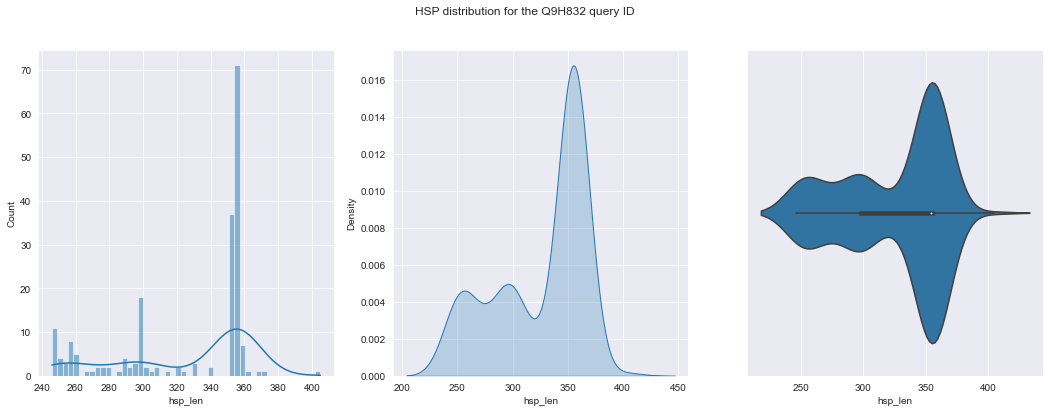

In [11]:
# Create bar plot for HSP hits of selected query ID
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(selected_dis['hsp_len'], kde = True, bins = 50, ax = ax1)
sns.kdeplot(selected_dis['hsp_len'], shade = True, ax = ax2)
sns.violinplot(x = selected_dis['hsp_len'], ax = ax3)
plt.suptitle(f'HSP distribution for the {id_dis} query ID')
plt.show()

The `histplot` shows the distribution of HSP lengths in the selected query ID by grouping the HSP lengths into bins or ranges along the x-axis and displaying the frequency of HSP lengths as the height of the corresponding bar on the y-axis.

The height of the `kdeplot` curve represents the estimated probability density of the variable being plotted at each point on the x-axis. For example, in the case of the HSP length, the height of the curve at a particular value of x represents the estimated density of observations around that value. The area under the curve represents the total probability of all possible values of the variable, which is equal to 1.

The `violinplot` provides the information about the interquartile range (thick gray line), median that is represented by a white dot and the rest of a distribution (thin gray line). The distribution's shape is presented on either side of the gray line through kernel density estimation. The wider sections of the violin plot represent a greater probability of the population taking on a specific value, while the narrower sections indicate a lower probability.

### 3. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

#### 3.1. MSA from the BLAST output
This code iterates through each row of the dataframe for a previously selected query ID. If there is no gap, it maps the amino acid from the subject sequence to the corresponding position in the query sequence, starting from the beginning of the query sequence. The resulting mapped amino acids are then added to a new count. In the end we have a FASTA file with the subject IDs and the aligned sequences.

In [12]:
# Retrieve a query sequence from query id
query_sequence = get_fasta(id_dis)
query_lines = query_sequence.split("\n")
query_sequence = "".join(query_lines[1:]) # its length will be used for building MSA
query_sequence

'MAESPTEEAATAGAGAAGPGASSVAGVVGVSGSGGGFGPPFLPDVWAAAAAAGGAGGPGSGLAPLPGLPPSAAAHGAALLSHWDPTLSSDWDGERTAPQCLLRIKRDIMSIYKEPPPGMFVVPDTVDMTKIHALITGPFDTPYEGGFFLFVFRCPPDYPIHPPRVKLMTTGNNTVRFNPNFYRNGKVCLSILGTWTGPAWSPAQSISSVLISIQSLMTENPYHNEPGFEQERHPGDSKNYNECIRHETIRVAVCDMMEGKCPCPEPLRGVMEKSFLEYYDFYEVACKDRLHLQGQTMQDPFGEKRGHFDYQSLLMRLGLIRQKVLERLHNENAEMDSDSSSSGTETDLHGSLRV'

In [13]:
# # 1. Build the MSA from the BLAST
# out_file = f'{directory}results/alignments/output_files/blast/{id_dis}_blast.fasta'

# with open(out_file, "w") as fout:
#     mapped_seq = ["-"] * len(query_sequence)

#     # Write the header line for the query sequence
#     fout.write(">{}\n".format(id_dis))

#     # Map the query sequence to the mapped_seq list
#     c = 0
#     for l_q in query_sequence:
#         if l_q != " " and l_q != '-':
#             mapped_seq[c] = l_q
#             c += 1

#     # Write the query_mapped_seq sequence to the output file
#     fout.write("{}\n".format("".join(mapped_seq)))

#     # Map the subject sequences to the mapped_seq list and write to the output file
#     for index, row in selected_dis.iterrows():
#         c = 0
#         query_start = row["query_start"]
#         for l_q, l_s in zip(row['query_seq'], row['subject_seq']):
#             if l_q != " " and l_q != '-': # if the initial aa from query is not empty or gapped
#                 mapped_seq[query_start + c - 1] = l_s if l_s != " " else "-" # assign aa to subject
#                 c += 1
#             #if row['subject_id'] == id_dis:
#                 #continue
#         fout.write(">{}\n{}\n".format(row["subject_id"], "".join(mapped_seq)))


#### 3.2. MSA from the ClustalOmega, MAFFT

Initially, we need to preprocess the dataframe into a suitable input format file for ClustalOmega and MAFFT.

In [14]:
# # 2. Retrieve the unaligned sequence from the local machine
# input_file = f'{directory}results/alignments/input_files/{id_dis}_input.fasta'

# with open(input_file, 'w') as fout:
#     # Write the query sequence to the output file as the first line
#     fout.write(">{}\n{}\n".format(id_dis, query_sequence))

#     for index, row in selected_dis.iterrows():
#         accession = row['subject_id']
#         sequence = get_fasta(accession)
#         if id_dis == accession: # remove duplicates
#             continue
#         fout.write(sequence)

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [15]:
# Prepare all sequences for the following comparison
al_blast = f'{directory}results/alignments/output_files/blast/{id_dis}_blast.fasta'
al_clustal = f'{directory}results/alignments/output_files/clustal/{id_dis}_clustal.fasta'
al_mafft = f'{directory}results/alignments/output_files/mafft/{id_dis}_mafft.fasta'

blast_seqs = get_seqs(al_blast, 'blast', id_dis)
clustal_seqs = get_seqs(al_clustal, 'clustal', id_dis)
mafft_seqs = get_seqs(al_mafft, 'mafft', id_dis)

# The number of sequences may differ
blast_seqs.shape, clustal_seqs.shape, mafft_seqs.shape

((201, 354), (199, 354), (199, 354))

### 4. Defining disordered regions in MSA

In [16]:
# Extract the lists of start and end regions
start_regions = filtered_curated['start'].tolist()
end_regions = filtered_curated['end'].tolist()
print(f"The lists of start and end positions of the {id_dis} disordered regions: \n"
      f"Start regions: {start_regions}, \n"
      f"End regions: {end_regions}")

The lists of start and end positions of the Q9H832 disordered regions: 
Start regions: [1, 327], 
End regions: [99, 354]


In [49]:
# Trim disordered regions from MSA BLAST
regions = trim_dis_regions(al_blast, id_dis, start_regions, end_regions)

# Look at the resulting regions
dis_seqs = get_seqs(regions, 'disordered', id_dis)
print(id_dis, dis_seqs.shape)
dis_seqs[:10]

Q9H832 (201, 354)


array([['M', 'A', 'E', ..., 'L', 'R', 'V'],
       ['M', 'A', 'E', ..., 'L', 'R', 'V'],
       ['M', 'A', 'E', ..., 'L', 'R', 'V'],
       ...,
       ['M', 'A', 'E', ..., 'L', 'R', 'V'],
       ['M', 'A', 'E', ..., 'L', 'R', 'V'],
       ['M', 'A', 'E', ..., 'L', 'R', 'V']], dtype='<U1')

In [48]:
# Extract each disordered region in a separate .fasta file
sep_regions = select_dis_regions(al_blast, id_dis, start_regions, end_regions)



Skipping file: .DS_Store


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (402,) + inhomogeneous part.

### 5. Analysing the quality of prediction

For calculation of the `entropy` we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With `occupancy` we define the proportion of non-missing (non-gap) values in the column.

### 5.1. Calculation of occupancy and entropy for initial MSA

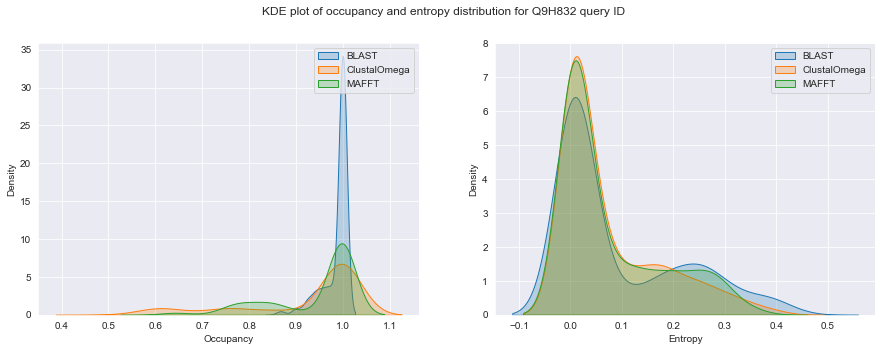

In [51]:
# Calculate the occupancy and entropy for each type of MSA
blast_calc = stats_calculation(blast_seqs)
clustal_calc = stats_calculation(clustal_seqs)
mafft_calc = stats_calculation(mafft_seqs)

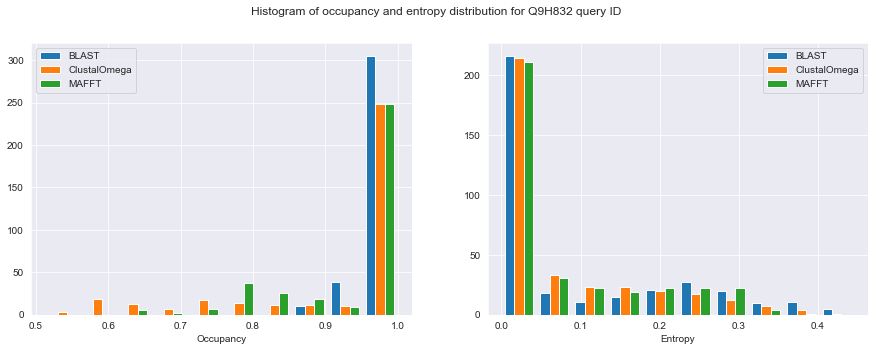

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(blast_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(clustal_calc['occupancy'], shade = True, ax = ax1)
sns.kdeplot(mafft_calc['occupancy'], shade = True, ax = ax1)

sns.kdeplot(blast_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(clustal_calc['entropy'], shade = True, ax = ax2)
sns.kdeplot(mafft_calc['entropy'], shade = True, ax = ax2)

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'KDE plot of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

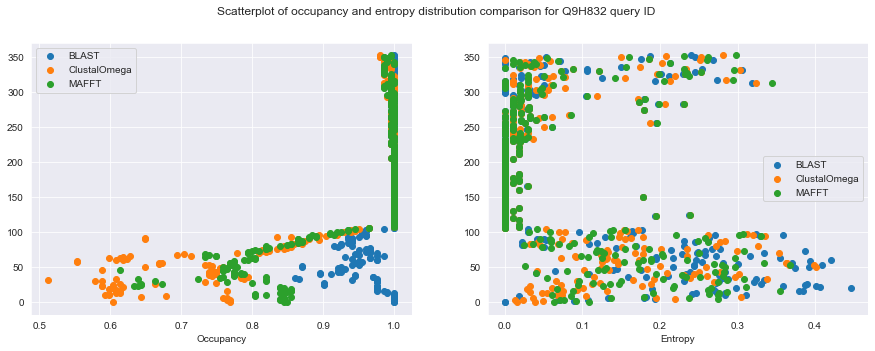

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist([blast_calc['occupancy'], clustal_calc['occupancy'], mafft_calc['occupancy']])
ax2.hist([blast_calc['entropy'], clustal_calc['entropy'], mafft_calc['entropy']])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])

ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')

plt.suptitle(f'Histogram of occupancy and entropy distribution for {id_dis} query ID')
plt.show()

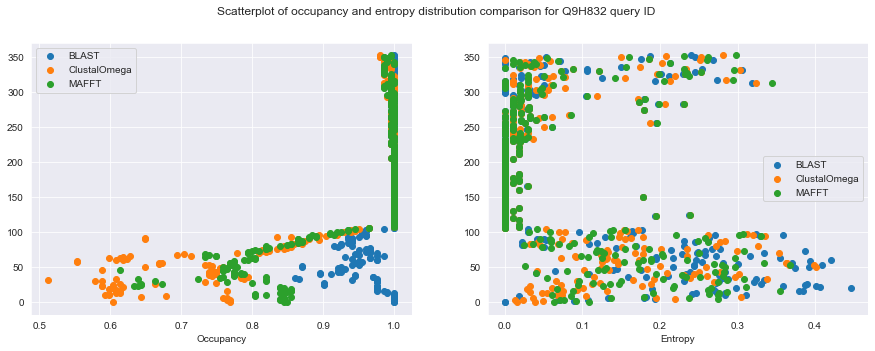

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(blast_calc['occupancy'], blast_calc['pos'])
ax1.scatter(clustal_calc['occupancy'], clustal_calc['pos'])
ax1.scatter(mafft_calc['occupancy'], mafft_calc['pos'])

ax2.scatter(blast_calc['entropy'], blast_calc['pos'])
ax2.scatter(clustal_calc['entropy'], clustal_calc['pos'])
ax2.scatter(mafft_calc['entropy'], mafft_calc['pos'])

ax1.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax2.legend(['BLAST', 'ClustalOmega', 'MAFFT'])
ax1.set_xlabel('Occupancy')
ax2.set_xlabel('Entropy')
plt.suptitle(f'Scatterplot of occupancy and entropy distribution comparison for {id_dis} query ID')
plt.show()

### 5.2. Calculation of occupancy and entropy for disordered regions MSA

In [43]:
dis_calc = stats_calculation(dis_seqs)
dis_calc.head()